# Visualizing difference with metric heatmap

Metric compuation procedure is described in [Metric for evaluating difference between seismograms](./Metrics_study_intro.ipynb)

Here we calculate STFT on all traces and do not average it, but visualize the difference between seismograms using this heatmap

In [5]:
import sys
sys.path.append('..')

import numpy as np

from functools import reduce

from matplotlib import pyplot as plt
from matplotlib import patches

from seismicpro.batchflow import Dataset
from seismicpro.src import SeismicBatch, FieldIndex

from utils import get_cv, draw_modifications_dist, validate_all, get_modifications_list, get_windowed_spectrogram_dists

## Loading Data

In [6]:
base_path = '/notebooks/data/metrics_study_ibm_outputs/4_Metrix_QC/'
      
paths = {
    'lift': '1_NA_qc_out_DN03.sgy', 
    'raw': '1_NA_qc_input_DN01.sgy',
    'm_1': '1_NA_qc_IBM_SUP.sgy',
    'm_2': '1_NA_qc_IBM_UNSUP.sgy',
    'm_3': '1_NA_qc_GPN_1dUnet.sgy'
}

field_index = reduce(lambda x, y: x.merge(y), 
                     (FieldIndex(name=name, path=base_path+path, extra_headers=['offset']) for name, path in paths.items()))

batch = (Dataset(field_index, SeismicBatch)
         .next_batch(len(field_index))
         .load(fmt='segy', components=tuple(paths.keys())))

cv = get_cv([batch.__getattr__(c)[0] for c in batch.components])

print("Number of fields: {}".format(len(field_index)))

Number of fields: 6


## Function to draw heatmaps

In [69]:
def draw_modifications_heatmaps(modifications, traces_frac=0.1, agg_traces=None, dist_fn='sum_abs',  # pylint: disable=too-many-arguments
                            vmin=None, vmax=None, figsize=(15, 15),
                            time_frame_width=100, noverlap=None, window='boxcar',
                            fontsize=12, aspect=None,
                            save_to=None):
    
        
    if not isinstance(agg_traces, (list, tuple)):
        agg_traces = [agg_traces]

    x, y = 2 + len(agg_traces), len(modifications) - 1
    _, axs = plt.subplots(x, y, figsize=figsize)

    if not isinstance(axs, np.ndarray):
        axs = np.array([axs])

    origin, _ = modifications[0]
    n_traces, n_ts = origin.shape
    n_use_traces = int(n_traces*traces_frac)

    for i, (mod, description) in enumerate(modifications[1:]):
        dist_m = get_windowed_spectrogram_dists(mod, origin,
                                                dist_fn=dist_fn, time_frame_width=time_frame_width,
                                                noverlap=noverlap, window=window)

        dist = np.mean(dist_m[:n_use_traces])
        rectangle_width = n_use_traces
        for j, agg in enumerate(agg_traces):
            hm = dist_m
            if agg:
                traces, times = dist_m.shape
                hm = np.mean(dist_m[:(traces//agg)*agg].reshape(agg, -1, times), axis=0)
                rectangle_width = n_use_traces//agg

            axs[j, i].imshow(hm.T, vmin=vmin[0], vmax=vmax[0], cmap='gray')
            rect = patches.Rectangle((0, 0), rectangle_width, n_ts, edgecolor='r', facecolor='none', lw=1)
            axs[j, i].add_patch(rect)
            axs[j, i].set_title("{} heatmap, traces aggr: {},\n{} distance from LIFT is: {:.4}"
                                .format(description, agg, dist_fn, dist), 
                                fontsize=fontsize)
            if aspect:
                axs[j, i].set_aspect(aspect)

        axs[-2, i].imshow(np.abs(mod - origin).T, vmin=vmin[1], vmax=vmax[1], cmap='gray')
        rect = patches.Rectangle((0, 0), n_use_traces, n_ts, edgecolor='r', facecolor='none', lw=1)
        axs[-2, i].add_patch(rect)
        axs[-2, i].set_title("{} - LIFT difference"
                             .format(description, dist_fn, np.mean(dist_m[:n_use_traces])), 
                             fontsize=fontsize)
        if aspect:
            axs[1, i].set_aspect(aspect)

        axs[-1, i].hist(dist_m.flatten())
        axs[-1, i].set_yscale('log')
        axs[-1, i].set_title("{}, heatmap histogram".format(description), fontsize=fontsize)

    if save_to:
        plt.savefig(save_to, transparent=True)

    plt.show()

## Visualization

Draw seismograms

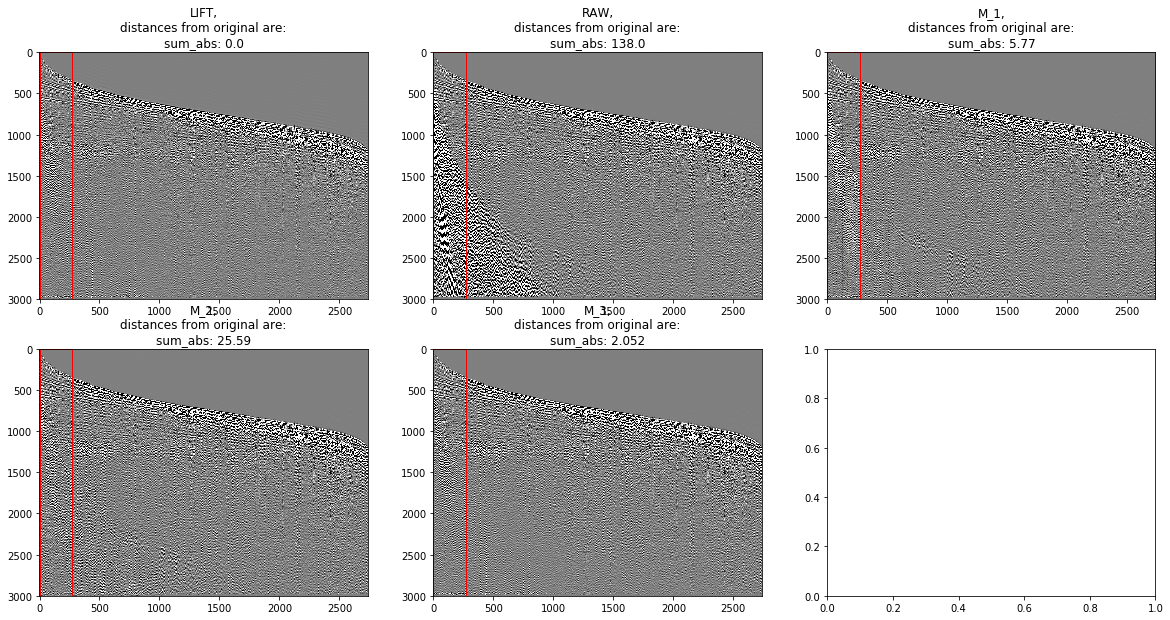

In [70]:
i=0
mods = get_modifications_list(batch, i)
draw_modifications_dist(mods, vmin=-cv, vmax=cv, fontsize=12, figsize=(20, 10), n_cols=3, aspect='auto')

Here we draw metric heatmaps for different outputs, as well as simple absolute difference between LIFT and corresponding output

We also provide metric heatmaps histograms for reference

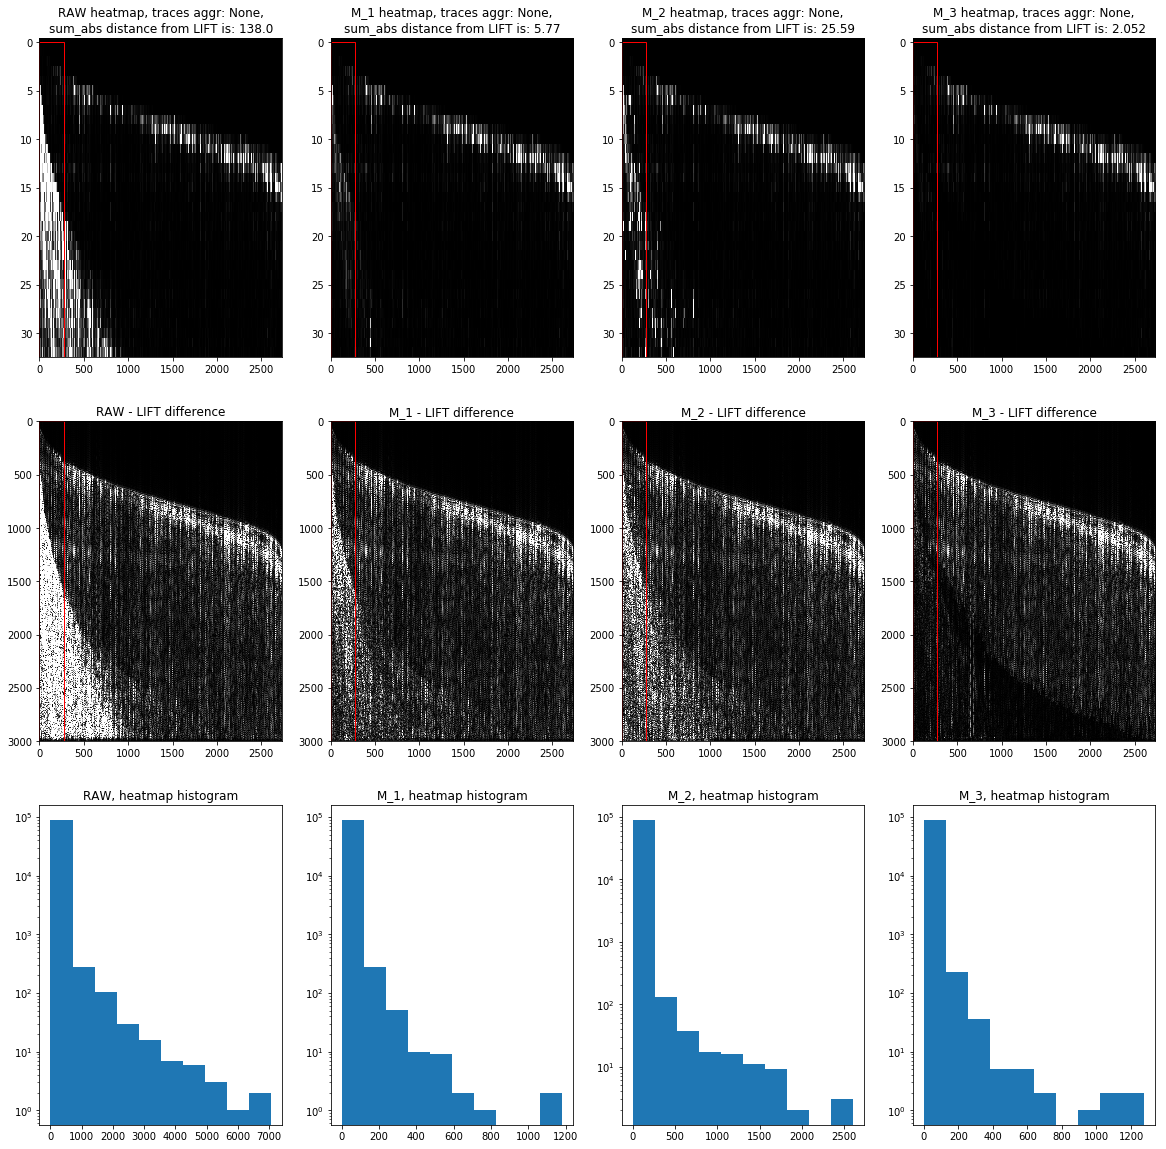

In [71]:
draw_modifications_heatmaps(mods, vmin=[0, 0], vmax=[100, cv],  figsize=(20, 20), aspect='auto')

### Effect of traces aggregation

Let's also see how visualisation expressiveness changes if we aggregate each `agg_traces` before drawing the heatmap

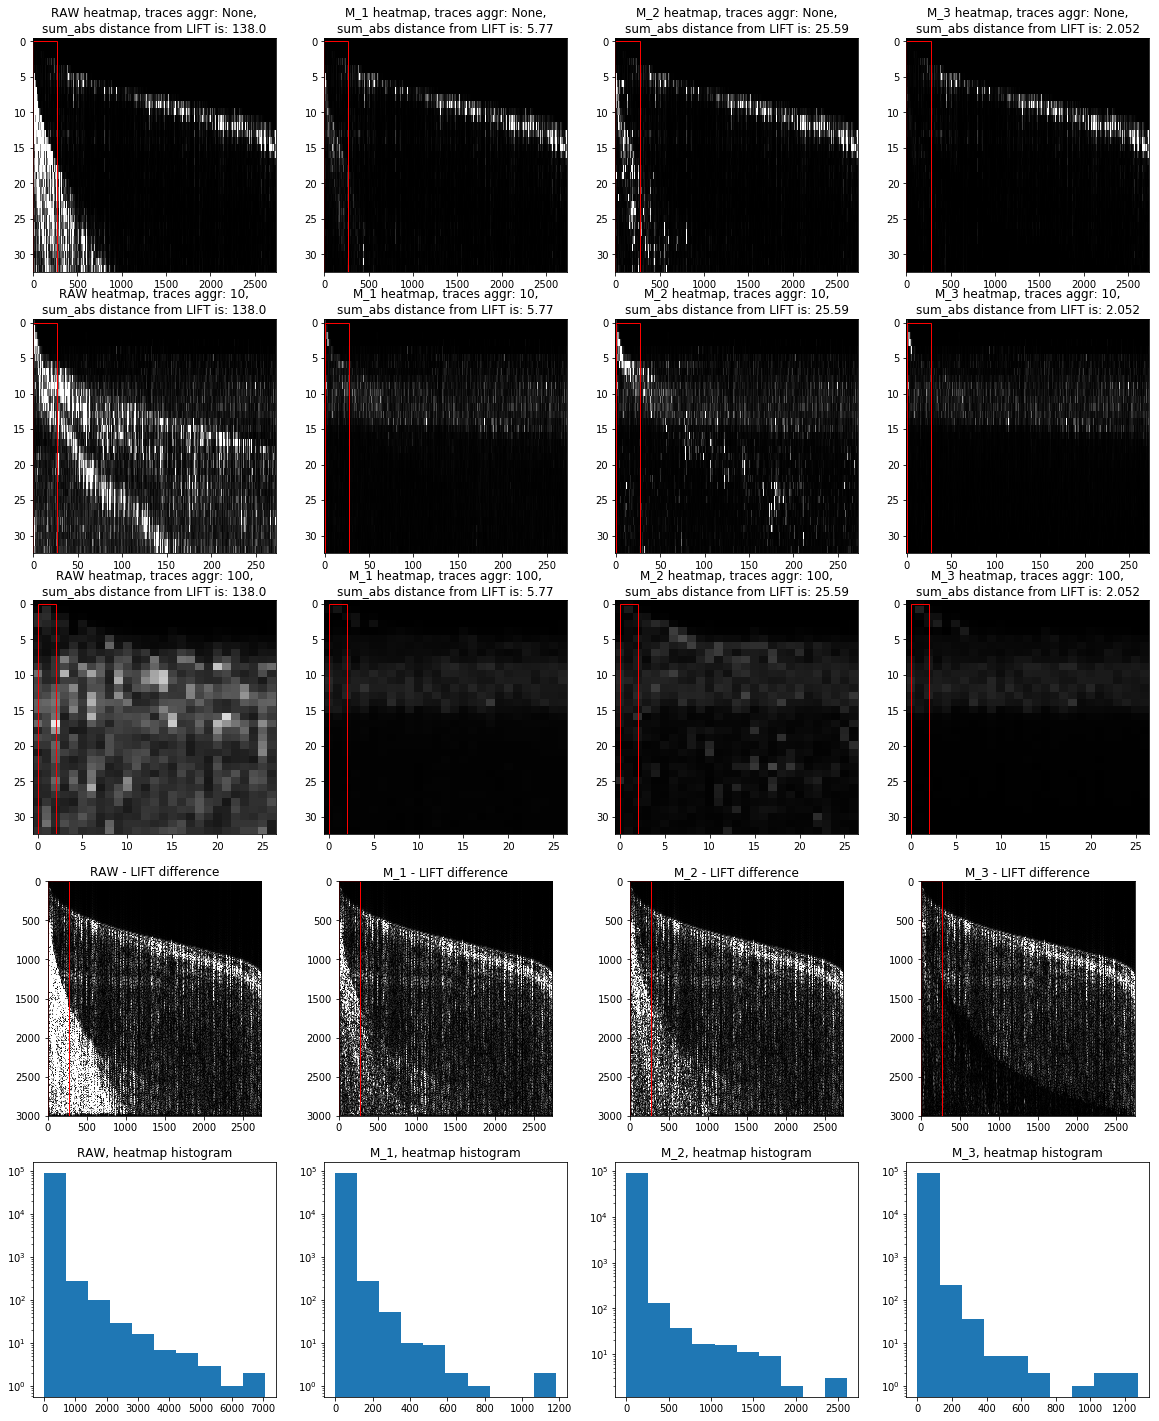

In [72]:
draw_modifications_heatmaps(mods, agg_traces=[None, 10, 100],  vmin=[0, 0], vmax=[100, cv],  figsize=(20, 25), aspect='auto')